In [1]:
import sys
import folium  
import os
import urllib
import zipfile
import geopandas as gpd
import seaborn as sns
import shapely.geometry
from shapely.geometry import Point, Polygon, MultiPolygon
import libpysal as lps
from libpysal import weights 
from pysal.explore import esda 
from libpysal.weights import Queen, Rook, KNN
import pysal as ps
import numpy as np
import pandas as pd
import spreg
import mgwr
import mapclassify
import matplotlib.pyplot as plt
from matplotlib import colors 
import pysal.viz as viz
import scipy.stats as ss
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

/Users/rajandosanjh/opt/anaconda3/envs/sds2023/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/Users/rajandosanjh/opt/anaconda3/envs/sds2023/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/Users/rajand

In [2]:
lsoasuk = gpd.read_file('Data/map.geojson')
lsoasuk.head()

,objectid,lad16cd,lad16nm,lad16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E06000001,Hartlepool,NaN,447157,531476,-1.27023,54.676159,0.013041,0.879421,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
1,2,E06000002,Middlesbrough,NaN,451141,516887,-1.21099,54.544670,0.007484,0.535764,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54..."
2,3,E06000003,Redcar and Cleveland,NaN,464359,519597,-1.00611,54.567520,0.034014,1.266847,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."
3,4,E06000004,Stockton-on-Tees,NaN,444937,518183,-1.30669,54.556911,0.028479,1.424195,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54..."
4,10,E06000010,"Kingston upon Hull, City of",NaN,511894,431716,-0.30380,53.769791,0.009740,0.782168,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53..."


In [3]:
lsoasuk = lsoasuk.rename(columns = {'lad16cd':'Area Code'})
lsoasuk

,objectid,Area Code,lad16nm,lad16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E06000001,Hartlepool,NaN,447157,531476,-1.27023,54.676159,0.013041,0.879421,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
1,2,E06000002,Middlesbrough,NaN,451141,516887,-1.21099,54.544670,0.007484,0.535764,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54..."
2,3,E06000003,Redcar and Cleveland,NaN,464359,519597,-1.00611,54.567520,0.034014,1.266847,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."
3,4,E06000004,Stockton-on-Tees,NaN,444937,518183,-1.30669,54.556911,0.028479,1.424195,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54..."
4,10,E06000010,"Kingston upon Hull, City of",NaN,511894,431716,-0.30380,53.769791,0.009740,0.782168,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53..."
...,...,...,...,...,...,...,...,...,...,...,...
646,310,E09000017,Hillingdon,NaN,508166,183120,-0.44182,51.536629,0.015001,0.717463,"POLYGON ((-0.49417 51.63105, -0.50061 51.59969..."
647,311,E09000018,Hounslow,NaN,512744,174965,-0.37844,51.462429,0.007243,0.720275,"MULTIPOLYGON (((-0.28078 51.50285, -0.40690 51..."
648,312,E09000019,Islington,NaN,531158,184647,-0.10992,51.545479,0.001923,0.235079,"POLYGON ((-0.11758 51.57415, -0.14242 51.56912..."
649,313,E09000020,Kensington and Chelsea,NaN,525757,179053,-0.18976,51.496441,0.001572,0.241423,"POLYGON ((-0.22759 51.53015, -0.22851 51.53035..."


In [4]:
# define a function to convert each geometry to MultiPolygon
def to_multipolygon(geom):
    return MultiPolygon([geom]) if geom.geom_type == 'Polygon' else geom

# apply the function to all geometry columns
lsoasuk = lsoasuk.apply(lambda row: row.apply(to_multipolygon) if row.name.startswith('geometry') else row)

In [5]:
lsoasuk1 = lsoasuk[['Area Code', 'lad16nm','geometry']].dropna()
lsoasuk1.head()

,Area Code,lad16nm,geometry
0,E06000001,Hartlepool,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
1,E06000002,Middlesbrough,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54..."
2,E06000003,Redcar and Cleveland,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."
3,E06000004,Stockton-on-Tees,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54..."
4,E06000010,"Kingston upon Hull, City of","MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53..."


In [6]:
health = pd.read_csv('Data/Book4.csv')
health.head()

,Area Code,Area Name,Area Type [Note 3],2015,2016,2017,2018,2019,2020
0,E92000001,ENGLAND,Country,100.0,100.5,100.7,100.7,100.5,100.1
1,E12000001,North East,Region,94.6,94.8,94.3,93.6,92.9,92.7
2,E06000001,Hartlepool,LTLA,88.2,87.9,85.5,84.5,84.6,86.2
3,E06000002,Middlesbrough,LTLA,82.9,81.1,81.9,79.9,78.3,78.6
4,E06000003,Redcar and Cleveland,LTLA,96.7,96.8,97.7,95.8,94.6,91.4


In [7]:
health1 = health[['Area Code', '2020']].dropna()
health1.head()

,Area Code,2020
0,E92000001,100.1
1,E12000001,92.7
2,E06000001,86.2
3,E06000002,78.6
4,E06000003,91.4


In [8]:
gdf = gpd.GeoDataFrame(lsoasuk1.join(health1[['2020']]), crs=lsoasuk1.crs)
gdf = gdf[['Area Code', 'lad16nm', '2020', 'geometry']].dropna()
gdf.head()

,Area Code,lad16nm,2020,geometry
0,E06000001,Hartlepool,100.1,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
1,E06000002,Middlesbrough,92.7,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54..."
2,E06000003,Redcar and Cleveland,86.2,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."
3,E06000004,Stockton-on-Tees,78.6,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54..."
4,E06000010,"Kingston upon Hull, City of",91.4,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53..."


<Axes: >

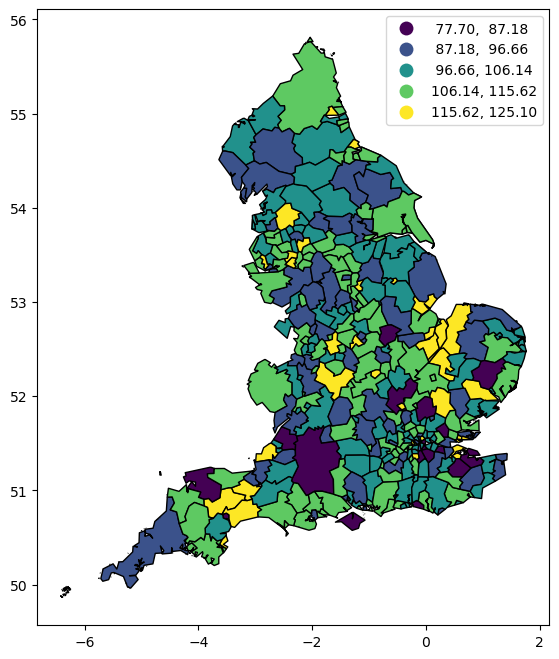

In [9]:
fig, ax = plt.subplots(1, figsize = (8, 8))
gdf.plot(column = '2020', cmap='viridis',
           scheme = 'equal_interval', k=5,
           edgecolor = 'black',
           legend = True, ax=ax)

In [10]:
####SPATIAL LAG####

In [11]:
def plotHealthLocation (axes, idx, var, xlim_coords, ylim_coords):
    gdf.plot(column=var,
        cmap = 'viridis', scheme = 'quantiles', k=5,
        legend=True, legend_kwds={"title":"var", "loc":2},
        ax = axes
    )
    
    gdf.loc[[idx]].plot(ax=axes, color = 'none', edgecolor = 'black', linewidth =3)
    
    axes.set_xlim(xlim_coords)
    axes.set_ylim(ylim_coords)
    axes.set_title(gdf.loc[idx]['Area Code'])
plt.show()

In [18]:
w = weights.KNN.from_dataframe(gdf, k=5)
w.transform = 'R'

In [19]:
gdf['Health_lag'] = weights.spatial_lag.lag_spatial(w, gdf['2020'])
gdf.head()

,Area Code,lad16nm,2020,geometry,Health_lag
0,E06000001,Hartlepool,100.1,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54...",103.96
1,E06000002,Middlesbrough,92.7,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54...",105.44
2,E06000003,Redcar and Cleveland,86.2,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54...",106.82
3,E06000004,Stockton-on-Tees,78.6,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54...",108.26
4,E06000010,"Kingston upon Hull, City of",91.4,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53...",102.02


In [20]:
w1 = weights.KNN.from_dataframe(gdf, k=8)
w1.transform = 'R'

In [21]:
gdf['Health_lag8'] = weights.spatial_lag.lag_spatial(w1, gdf['2020'])
gdf.head()

,Area Code,lad16nm,2020,geometry,Health_lag,Health_lag8
0,E06000001,Hartlepool,100.1,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54...",103.96,103.0875
1,E06000002,Middlesbrough,92.7,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54...",105.44,101.6500
2,E06000003,Redcar and Cleveland,86.2,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54...",106.82,102.0875
3,E06000004,Stockton-on-Tees,78.6,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54...",108.26,105.3375
4,E06000010,"Kingston upon Hull, City of",91.4,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53...",102.02,104.7125


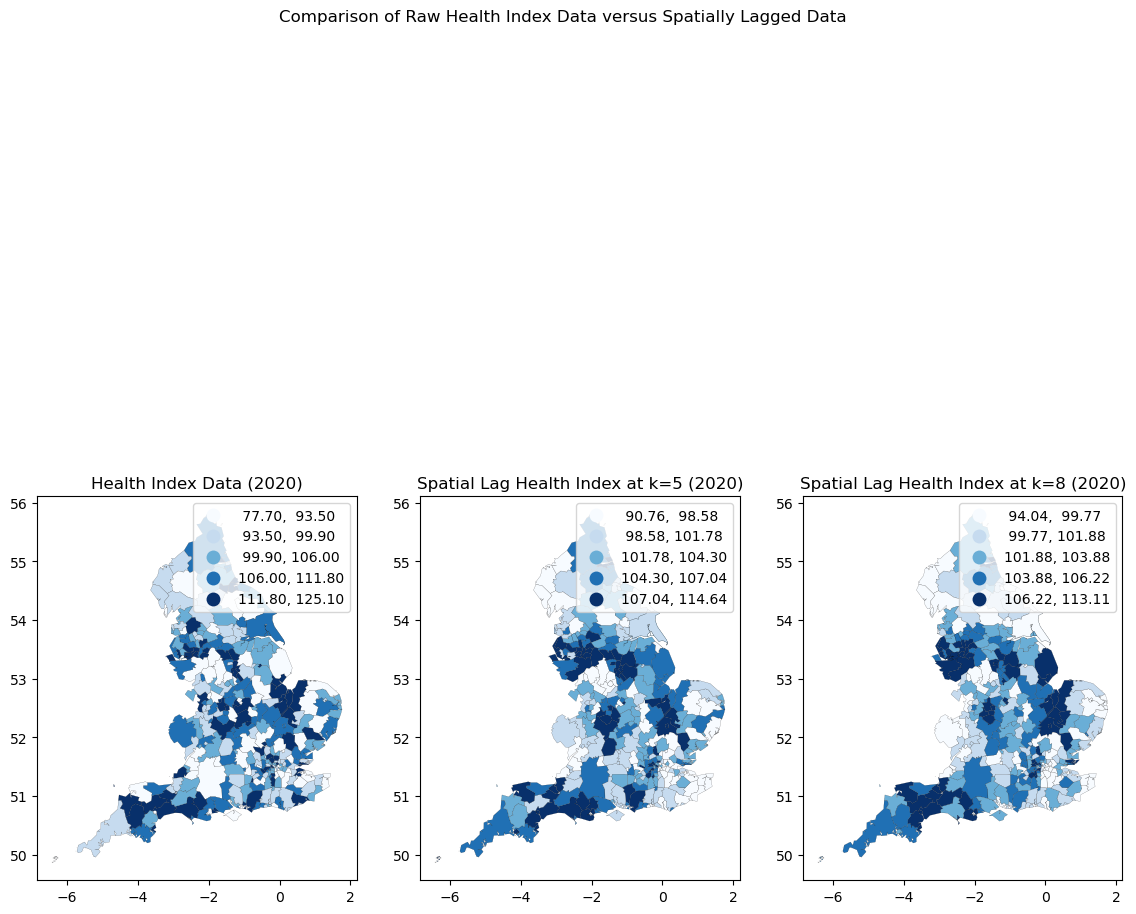

In [22]:
fig, axes = plt.subplots(1,3, figsize=(14, 14))
gdf.plot(column = '2020', cmap='Blues', scheme ='quantiles', k=5,
         linewidth=0.1, legend=True, edgecolor = 'black',
         ax=axes[0]
        )
axes[0].set_title("Health Index Data (2020)")

gdf.plot(column='Health_lag', cmap='Blues', scheme='quantiles', k=5, 
         linewidth =0.1, legend=True, edgecolor = 'black',
         ax=axes[1]
        )
axes[1].set_title("Spatial Lag Health Index at k=5 (2020)")

gdf.plot(column='Health_lag8', cmap='Blues', scheme='quantiles', k=5, 
         linewidth =0.1, legend=True, edgecolor = 'black',
         ax=axes[2]
        )
axes[2].set_title("Spatial Lag Health Index at k=8 (2020)")

plt.suptitle("Comparison of Raw Health Index Data versus Spatially Lagged Data")
plt.show()
         

In [23]:
###GLOBAL MORANS I###

In [24]:
moran = esda.moran.Moran(gdf['2020'], w)

In [25]:
round(moran.I,3)

0.049

In [26]:
moran.p_sim

0.07

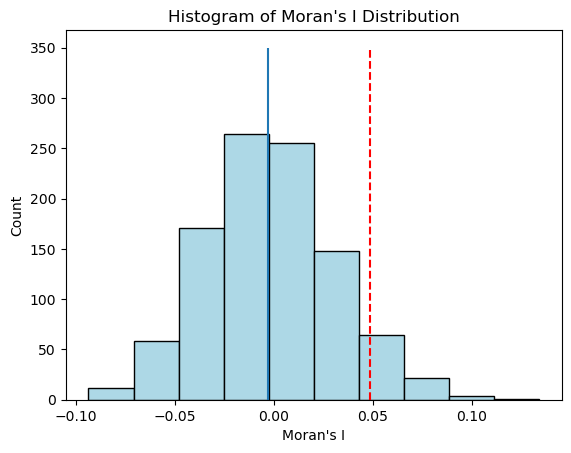

In [27]:
plt.hist(moran.sim, 10, facecolor='lightblue', edgecolor='black')
plt.vlines(moran.I, 0, 350, color='r', linestyle="--")
plt.vlines(moran.EI, 0, 350)
plt.title("Histogram of Moran's I Distribution")
plt.xlabel("Moran's I")
plt.ylabel("Count")
plt.show()

In [28]:
gdf['Health_lag'] = weights.spatial_lag.lag_spatial(w, gdf['2020'])

In [29]:
def standardize(df, var): 
    newname = var + '_z'
    df[newname] = (df[var] - df[var].mean()) / df[var].std()
standardize(gdf,'2020')
standardize(gdf,'Health_lag')

In [30]:
gdf.head()

,Area Code,lad16nm,2020,geometry,Health_lag,Health_lag8,2020_z,Health_lag_z
0,E06000001,Hartlepool,100.1,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54...",103.96,103.0875,-0.267507,0.223571
1,E06000002,Middlesbrough,92.7,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54...",105.44,101.6500,-1.022654,0.546872
2,E06000003,Redcar and Cleveland,86.2,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54...",106.82,102.0875,-1.685960,0.848329
3,E06000004,Stockton-on-Tees,78.6,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54...",108.26,105.3375,-2.461517,1.162892
4,E06000010,"Kingston upon Hull, City of",91.4,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53...",102.02,104.7125,-1.155315,-0.200215


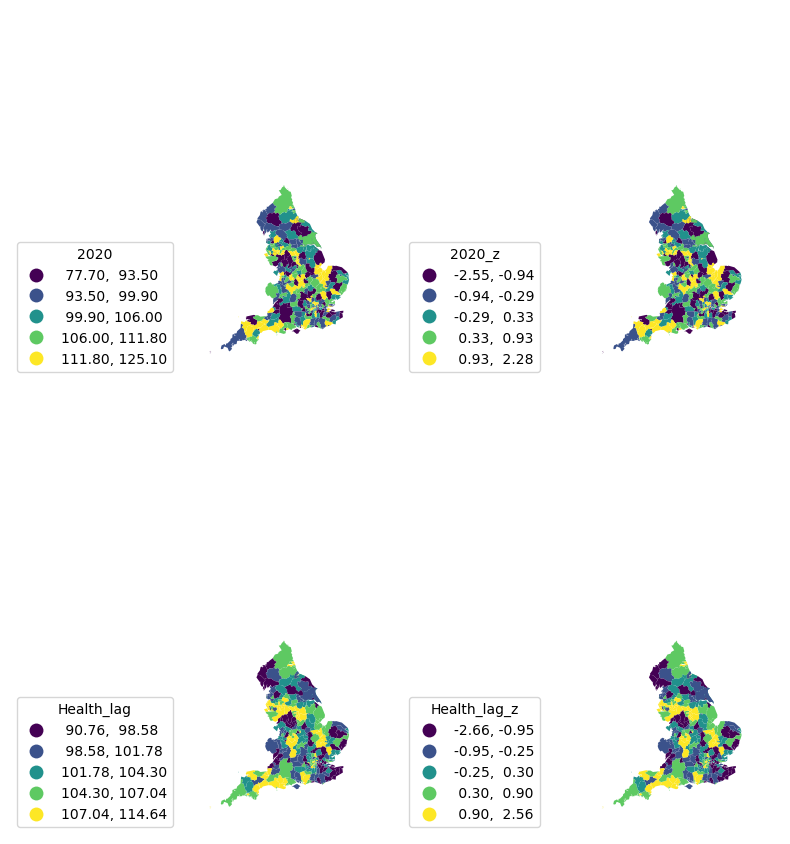

In [31]:
fig, ax = plt.subplots(2,2, figsize=(8,10))
ax=ax.flatten()
mapys = (49,62)
mapxs = (-18,4)
for i, p in enumerate(['2020','2020_z','Health_lag','Health_lag_z']):
    gdf.plot(column=p, cmap='viridis', scheme='quantiles', k=5,
linewidth=0.,
legend=True, legend_kwds={"title":p,"loc": 3}, ax=ax[i]
       )
    ax[i].set_ylim(mapys)
    ax[i].set_xlim(mapxs)
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

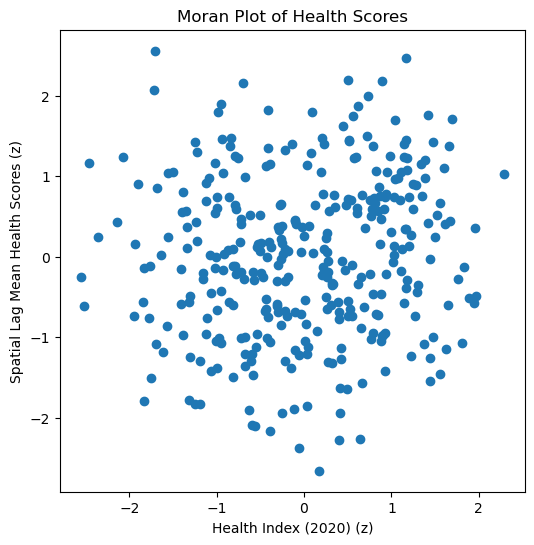

In [32]:
fig, ax = plt.subplots(1, figsize=(6, 6))

plt.scatter(gdf['2020_z'], gdf['Health_lag_z'])

ax.set_title('Moran Plot of Health Scores')
ax.set_xlabel("Health Index (2020) (z)")
ax.set_ylabel("Spatial Lag Mean Health Scores (z)")
plt.show()

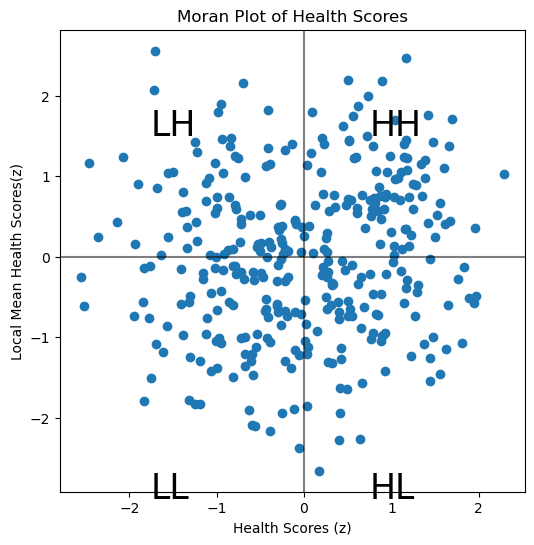

In [33]:
fig, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
plt.scatter(gdf['2020_z'], gdf['Health_lag_z']) # Add vertical and horizontal lines through zero 
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant 
plt.text(0.75, 1.5, "HH", fontsize=25) 
plt.text(0.75, -3, "HL", fontsize=25) 
plt.text(-1.75, 1.5, "LH", fontsize=25) 
plt.text(-1.75, -3, "LL", fontsize=25)
# Display
ax.set_title('Moran Plot of Health Scores') 
ax.set_xlabel("Health Scores (z)") 
ax.set_ylabel("Local Mean Health Scores(z)") 
plt.show()

In [34]:
def rules(row):
    if row['2020_z'] > 0:
        if row['Health_lag_z'] > 0: 
            return 'HH'
        else:
            return 'HL'
    else:
        if row['Health_lag_z'] > 0:
            return 'LH' 
        else:
            return 'LL' 

gdf['quadrant'] = gdf.apply(rules, 1)

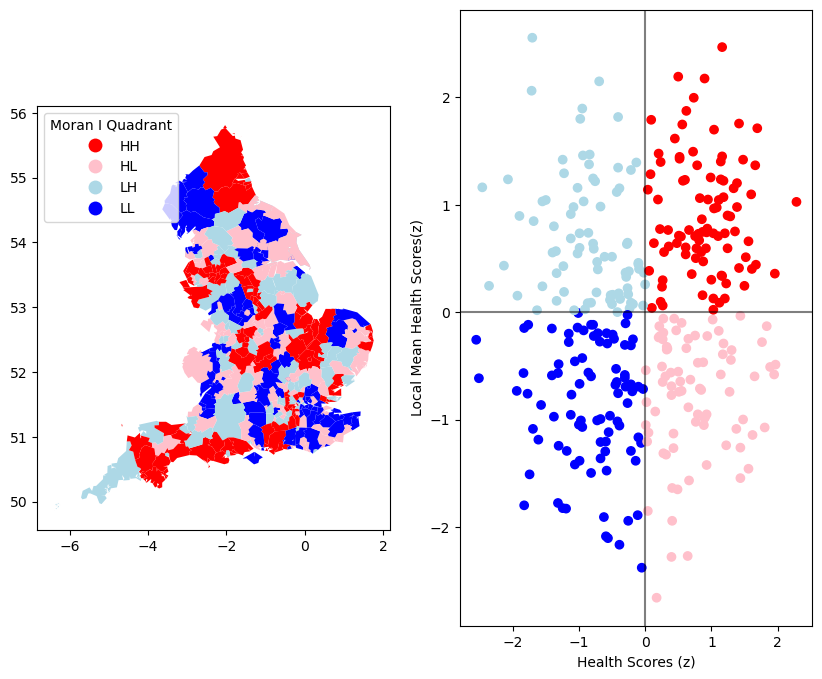

In [35]:
fig, ax = plt.subplots(1,2, figsize = (10,8))

qcolors = {'HH':'red', 'HL':'pink', 'LH':'lightblue', 'LL':'blue'}

gdf.plot(column='quadrant', categorical=True, cmap=colors.ListedColormap(qcolors.values()),
         k=2, edgecolor='white', linewidth=0.0,
         legend=True, legend_kwds={"title":"Moran I Quadrant","loc": 2},
         ax=ax[0])

ax[1].scatter(gdf['2020_z'], gdf['Health_lag_z'], c=gdf['quadrant'].map(qcolors))
ax[1].axvline(0, c='k', alpha=0.5)
ax[1].axhline(0, c='k', alpha=0.5)
ax[1].set_xlabel("Health Scores (z)")
ax[1].set_ylabel("Local Mean Health Scores(z)")
plt.show()

In [36]:
###LOCAL MORANS I###

In [37]:
lisa = esda.moran.Moran_Local(gdf['2020'], w)

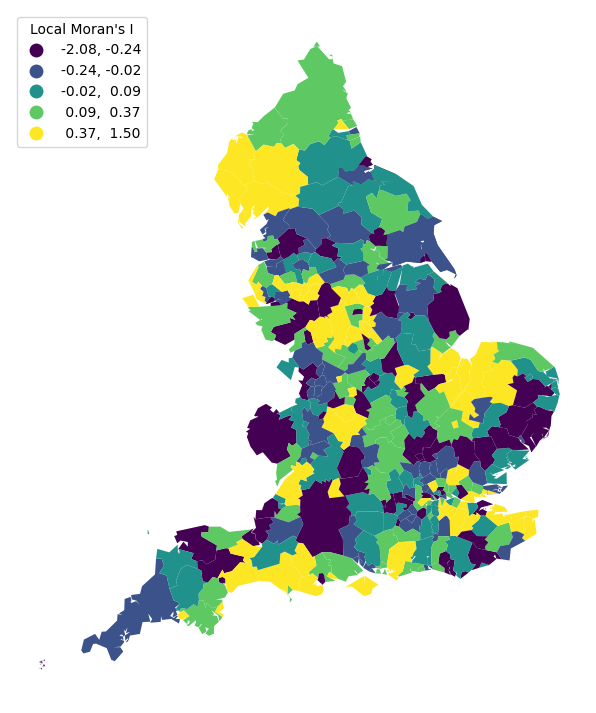

In [38]:
gdf['Is'] = lisa.Is

fig, ax = plt.subplots(1, figsize=(9,9))
gdf.plot(column='Is', cmap='viridis', scheme='quantiles', k=5, legend=True,
         legend_kwds={"title":"Local Moran's I", "loc": 2},
         ax=ax
        )
ax.set_axis_off()

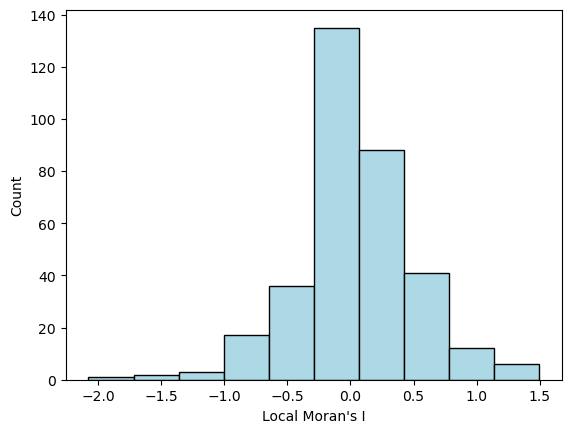

In [39]:
plt.hist(lisa.Is, 10, facecolor='lightblue', edgecolor='black')
plt.xlabel("Local Moran's I")
plt.ylabel("Count")
plt.show()

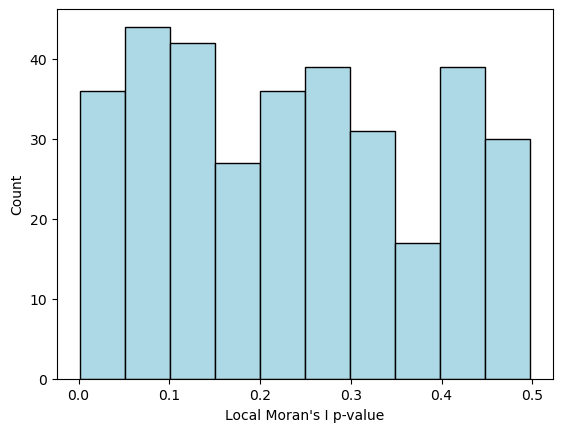

In [40]:
plt.hist(lisa.p_sim, 10, facecolor='lightblue', edgecolor='black')
plt.xlabel("Local Moran's I p-value")
plt.ylabel("Count")
plt.show()

In [41]:
gdf['p-sim'] = lisa.p_sim
sig = 1 * (lisa.p_sim < 0.05) 
slabels = ['non-sig.', 'significant'] 
labels = [slabels[i] for i in sig]
gdf['sig'] = labels
gdf[['sig','p-sim']].head(10)

,sig,p-sim
0,non-sig.,0.389
1,non-sig.,0.274
2,non-sig.,0.173
3,non-sig.,0.103
4,non-sig.,0.443
5,non-sig.,0.405
6,non-sig.,0.294
7,non-sig.,0.249
8,non-sig.,0.250
9,significant,0.016


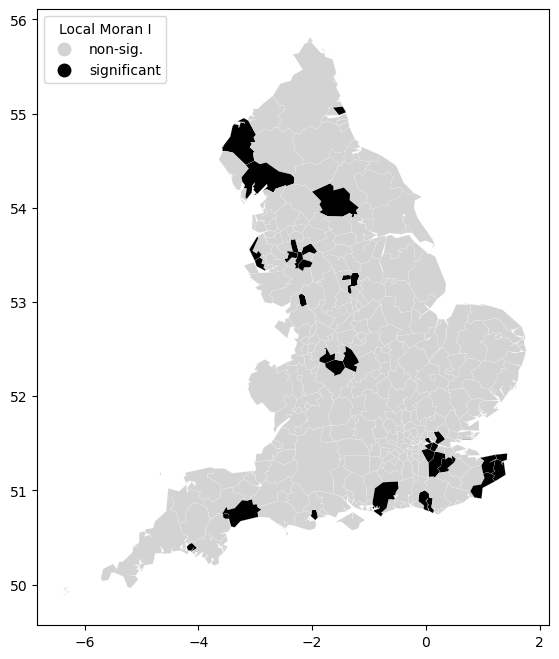

In [42]:
fig, ax = plt.subplots(1,figsize=(10,8))
sigcolors = {'non-sig.':'lightgrey', 'significant':'black'}
gdf.plot(column='sig', categorical=True, cmap=colors.ListedColormap(sigcolors.values()),
k=2, linewidth=0.1, edgecolor='white',
legend=True, legend_kwds={"title":'Local Moran I',"loc": 2}, ax=ax)
plt.show()

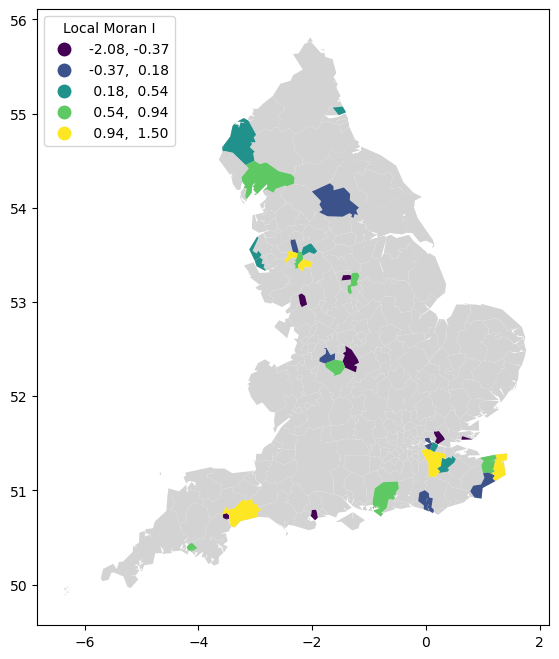

In [43]:
gdf['sigIs'] = np.where(gdf['sig'] == 'significant', gdf['Is'], np.nan)
fig, ax = plt.subplots(1, figsize=(10,8))
gdf.plot(color='lightgrey',linewidth=0.0,ax=ax)
gdf.plot(column='sigIs', cmap='viridis', scheme='quantiles',
k=5, edgecolor='white', linewidth=0.0,
legend=True, legend_kwds={"title":'Local Moran I',"loc": 2}, ax=ax)
plt.show()

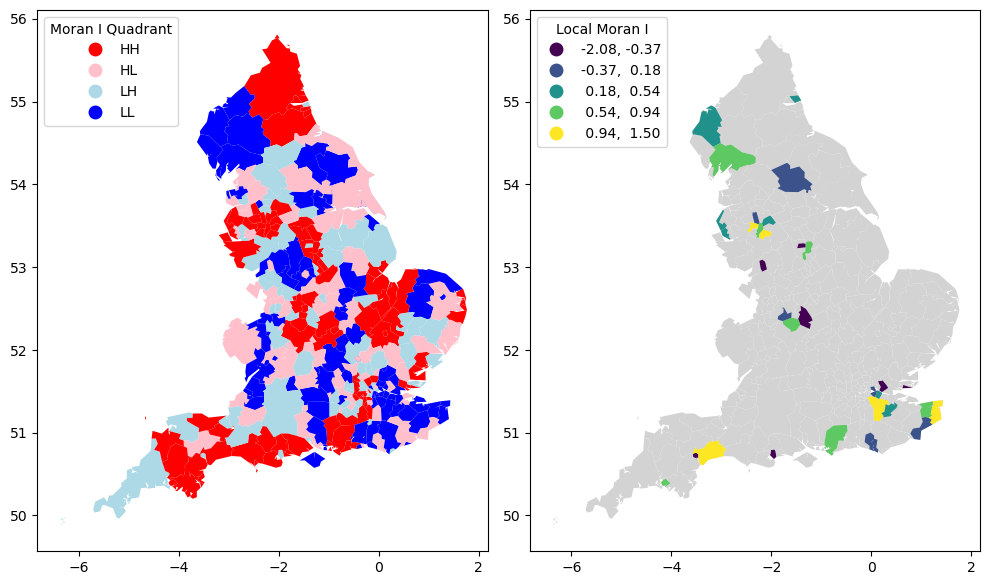

In [44]:
fig, ax = plt.subplots(1,2, figsize=(10,8))
qcolors = {'HH':'red', 'HL':'pink', 'LL':'lightblue', 'LH':'blue'}
gdf.plot(column='quadrant', categorical=True, cmap=colors.ListedColormap(qcolors.values()),
k=2, edgecolor='white', linewidth=0.0,
legend=True, legend_kwds={"title":'Moran I Quadrant',"loc": 2}, ax=ax[0])
gdf.plot(color='lightgrey',linewidth=0.0,ax=ax[1])
gdf.plot(column='sigIs', cmap='viridis', scheme='quantiles',
k=5, edgecolor='white', linewidth=0.0,
legend=True, legend_kwds={"title":'Local Moran I',"loc": 2}, ax=ax[1])
fig.tight_layout()
plt.show()

In [45]:
lisa.q[1:10]

array([2, 2, 2, 3, 2, 3, 2, 2, 2])

In [46]:
counts = [(j,(lisa.q==j).sum()) for j in range(1,5)]
counts

[(1, 94), (2, 82), (3, 86), (4, 79)]

In [47]:
qlabels = ['HH', 'LH', 'LL', 'HL'] #pysal scheme is HH=1, LH=2, LL=3, HL=4 
labels = [qlabels[i-1] for i in lisa.q] #list substituting 1-4 with HH-HL 
labels[1:10]

['LH', 'LH', 'LH', 'LL', 'LH', 'LL', 'LH', 'LH', 'LH']

In [48]:
gdf['qlabels'] = labels
[(qlabel, (gdf['qlabels']==qlabel).sum()) for qlabel in qlabels]

[('HH', 94), ('LH', 82), ('LL', 86), ('HL', 79)]

In [49]:
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 non-sig.', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

In [50]:
gdf['slabels'] = labels
[(spot_label, (gdf['slabels']==spot_label).sum()) for spot_label in spot_labels]

[('0 non-sig.', 306),
 ('1 hot spot', 13),
 ('2 doughnut', 6),
 ('3 cold spot', 11),
 ('4 diamond', 5)]

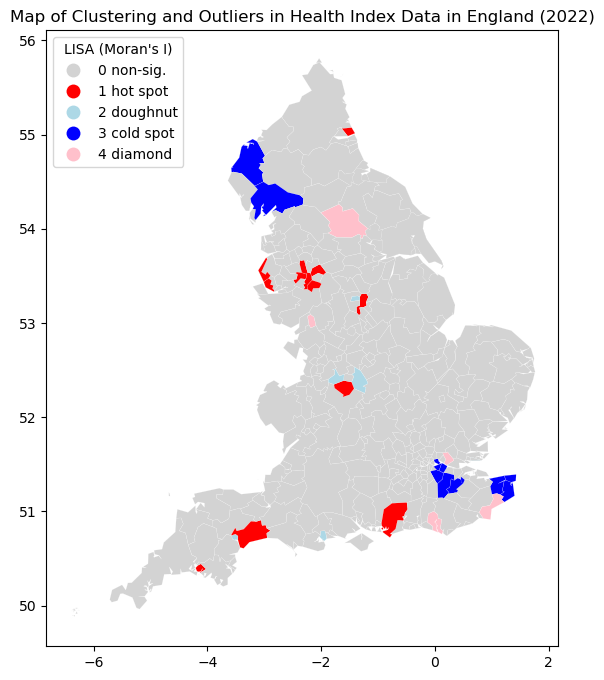

In [51]:
fig, ax = plt.subplots(1, figsize=(8,8))
sigcolors = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue','pink'])
gdf.plot(column='slabels', categorical=True,
k=2, cmap=sigcolors, linewidth=0.1, edgecolor='white', legend=True, legend_kwds={"title":"LISA (Moran's I)","loc": 2}, ax=ax)
plt.title("Map of Clustering and Outliers in Health Index Data in England (2022)")
plt.show()